## 代码参考  
https://github.com/osh/KerasGAN

In [65]:
import random
import numpy as np
from keras.layers import Input
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Model
from tqdm import tqdm
from IPython import display

## 读取数据集

In [66]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(np.min(X_train), np.max(X_train))
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


## 超参数设置

In [67]:
shp = X_train.shape[1:]
dropout_rate = 0.25

# Optim优化器
opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-5)

## 定义生成器

In [68]:
K.set_image_dim_ordering('th')  # 用theano的图片输入顺序
# 生成1 * 28 * 28的图片
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, kernel_initializer='glorot_normal')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)  # 转成200 * 14 * 14
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(100, (3, 3), padding="same", kernel_initializer='glorot_normal')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(50, (3, 3), padding="same", kernel_initializer='glorot_normal')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(1, (1, 1), padding="same", kernel_initializer='glorot_normal')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_30 (Batc (None, 39200)             156800    
_________________________________________________________________
activation_39 (Activation)   (None, 39200)             0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 200, 14, 14)       0         
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 200, 28, 28)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 100, 28, 28)       180100    
__________

## 定义辨别器

In [78]:
# 辨别是否来自真实训练集
d_input = Input(shape=shp)
H = Convolution2D(256, (5, 5), activation="relu", strides=(2, 2), padding="same")(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, (5, 5), activation="relu", strides=(2, 2), padding="same")(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 256, 14, 14)       6656      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256, 14, 14)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 256, 14, 14)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 512, 7, 7)         3277312   
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 512, 7, 7)         0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 512, 7, 7)         0         
__________

## 构造生成对抗网络

In [70]:
# 冷冻训练层
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)

# 构造GAN
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_18 (Model)             (None, 1, 28, 28)         4341425   
_________________________________________________________________
model_19 (Model)             (None, 2)                 9707266   
Total params: 14,048,691
Trainable params: 4,262,913
Non-trainable params: 9,785,778
_________________________________________________________________


##  训练

In [71]:
# 描绘损失收敛过程
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()
        
        
#  描绘生成器生成图像        
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [72]:
# 抽取训练集样本
ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]  

# 预训练辨别器
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)  # 生成器产生样本
X = np.concatenate((XT, generated_images))  
n = XT.shape[0]
y = np.zeros([2*n,2])  # 构造辨别器标签 one-hot encode
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, epochs=1, batch_size=32)
y_hat = discriminator.predict(X)

Epoch 1/1
20000/20000 [==============================] - 288s 14ms/step - loss: 0.0469


In [73]:
#  计算辨别器的准确率
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_total = y.shape[0]
n_right = (diff==0).sum()

print( "(%d of %d) right"  % (n_right, n_total))

(20000 of 20000) right


In [74]:
# 存储生成器和辨别器的训练损失
losses = {"d":[], "g":[]}

In [75]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):
    for e in tqdm(range(nb_epoch)):  
        
        # 生成器生成样本
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # 训练辨别器
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        # 存储辨别器损失loss
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)  
    
        # 生成器生成样本
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        # 存储生成器损失loss
        make_trainable(discriminator,False)  # 辨别器的训练关掉
        g_loss = GAN.train_on_batch(noise_tr, y2)
        losses["g"].append(g_loss)
        
        # 更新损失loss图
        if e%plt_frq == plt_frq-1:
            plot_loss(losses)
            plot_gen()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

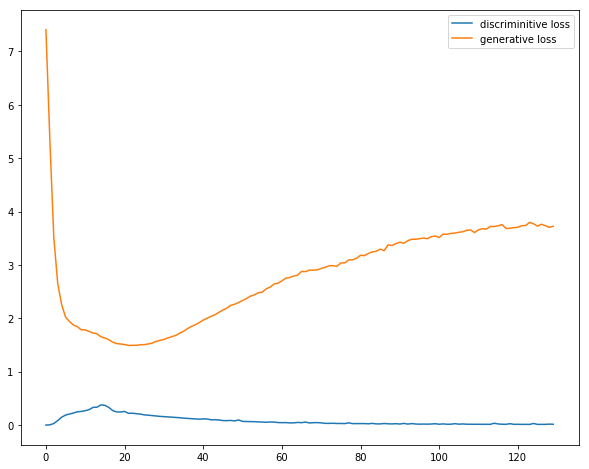

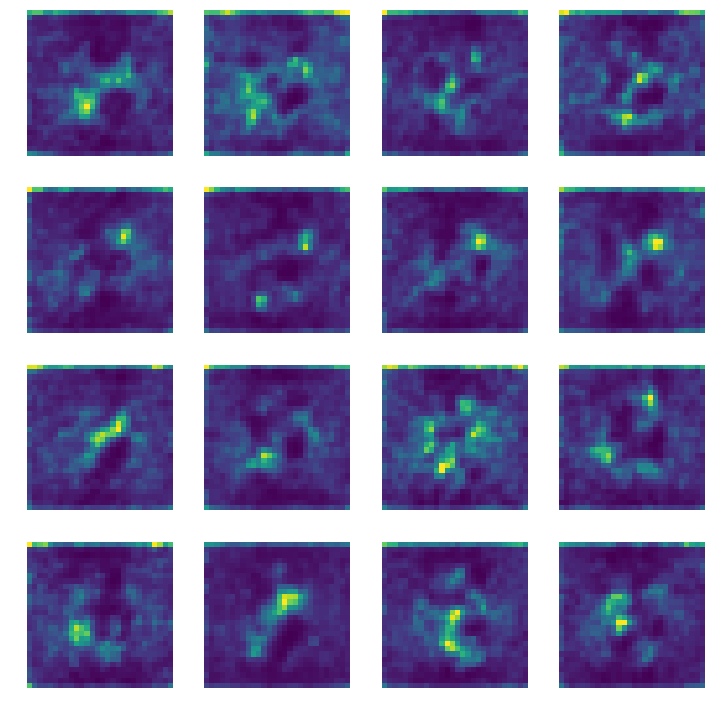




 13%|█▎        | 130/1000 [14:59<1:42:30,  7.07s/it]


 13%|█▎        | 131/1000 [15:06<1:41:04,  6.98s/it]


 13%|█▎        | 132/1000 [15:12<1:40:22,  6.94s/it]

KeyboardInterrupt: 

In [77]:
train_for_n(nb_epoch=1000, plt_frq=10,BATCH_SIZE=128)

## 调参技巧    
1.batch size  
2.adam优化器的learning rate  
3.迭代次数nb_epoch  
4.生成器generat和辨别器discriminator的网络结构  